# Chapter 7 - Ensemble Learning and Random Forests

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# Common Imports
import numpy as np
import os

# Make this notebook's output stable across runs
np.random.seed(42)

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'ensembles'

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + '.png', format='png', dpi=300)

If we aggregate the predictions of a group of predictors (such as classifiers or regressors), we will often get better predictions than with the best individual predictor. A group of predictors is called an ***ensemble***; thus, this technique is called ***Ensemble Learning***, and an Ensemble Learning algorithm is called an ***Ensemble method***.

For example, we can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, we just obtain the predictions of all individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a ***Random Forest***, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today.

## Voting Classifiers

Suppose, we have trained a few classifiers, each one achieving about $80\%$ accuracy. We have a Logistic Regression classifier, an SVM classifier, a Random Forest classifier, a K-Nearest Neighborsclassifier, and perhaps a few more.

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a **hard voting classifier**.

Ensemble methods work best when the predictors are as independent from one another as possible. One way to get diverse classifiers is to train them using very different algorithms. This increases the chance that they will make very different types of errors, improving the ensemble’s accuracy.

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


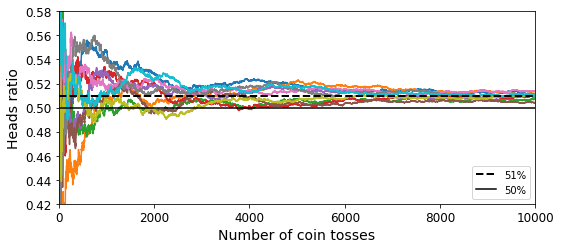

In [3]:
plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])

save_fig("law_of_large_numbers_plot")
plt.show()

The following code creates and trains a voting classifier in Scikit-Learn, composed of three diverse classifiers (the training set is the moons dataset): 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svm', svm_clf)],
    voting="hard"
)

In [6]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,...
                                        

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


The voting classifier slightly outperforms all the individual classifiers.

If all classifiers are able to estimate class probabilities (i.e., they have a `predict_proba()` method), then we can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called **soft voting**. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is replace `voting="hard"` with `voting="soft"` and ensure that all classifiers can estimate class probabilities.

In [8]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma="auto", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42,
                                                 solver='liblinear', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,...
                                        

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


We can see that the voting classifier achieves over $91\%$ accuracy!

## Bagging and Pasting

Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set. When sampling is performed with replacement, this method is called ***bagging*** (short for ***bootstrap aggregating***). When sampling is performed without replacement, it is called ***pasting***. 

In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor.

Scikit-Learn offers a simple API for both bagging and pasting with the `BaggingClassifier` class (or `BaggingRegressor` for regression). The following code trains an ensemble of $500$ Decision Tree classifiers, each trained on $100$ training instances randomly sampled from the training set with replacement (this is an example of bagging, but if we want to use pasting instead, just set `bootstrap=False`). The `n_jobs` parameter tells Scikit-Learn the number of CPU cores to use for training and predictions ($–1$ tells Scikit-Learn to use all available cores):

In [10]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score 

print(accuracy_score(y_test, y_pred))

0.904


The `BaggingClassifier` automatically performs soft voting instead of hard voting if the base classifier can estimate class probabilities (i.e., if it has a `predict_proba()` method), which is the case with Decision Trees classifiers.

Figure below compares the decision boundary of a single Decision Tree with the decision boundary of a bagging ensemble of 500 trees (from the preceding code), both trained on the moons dataset. 

In [12]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_tree))

0.856


In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new  = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.80)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_trees_without_and_with_bagging_plot


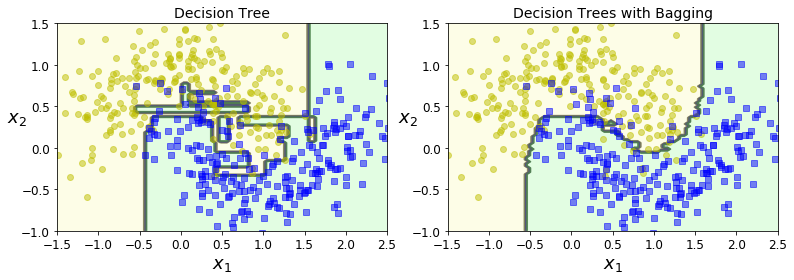

In [14]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)

save_fig("decision_trees_without_and_with_bagging_plot")
plt.show()

As we can see, the ensemble’s predictions will likely generalize much better than the single Decision Tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular).

## Out-of-Bag Evaluation

By default a `BaggingClassifier` samples `m` training instances with replacement(`bootstrap=True`), where `m` is the size of the training set. This means that only about $63\%$ of the training instances are sampled on average for each predictor. The remaining $37\%$ of the training instances that are not sampled are called out-of-bag (oob) instances. 

Note that they are not the same $37\%$ for all predictors. Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set or cross-validation.

We can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

In Scikit-Learn, set `oob_score=True` when creating a `BaggingClassifier` to request anautomatic oob evaluation after training. The following code demonstrates this. The resulting evaluation score is available through the `oob_score_` variable:

In [15]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=42
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

According to this oob evaluation, this `BaggingClassifier` is likely to achieve about $89.8\%$ accuracy on the test score. Let's verify this:

In [16]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

$91.2\%$ accuracy on the test set - better.

The oob decision function for each training instance is also available through the `oob_decision_function_` variable. In this case (since the base estimator has a `predict_proba()` method) the decision function returns the class probabilities for each training instance.

In [17]:
bag_clf.oob_decision_function_

array([[0.32352941, 0.67647059],
       [0.35625   , 0.64375   ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06145251, 0.93854749],
       [0.35465116, 0.64534884],
       [0.01142857, 0.98857143],
       [0.98930481, 0.01069519],
       [0.97409326, 0.02590674],
       [0.7370892 , 0.2629108 ],
       [0.0049505 , 0.9950495 ],
       [0.75      , 0.25      ],
       [0.82681564, 0.17318436],
       [0.98461538, 0.01538462],
       [0.06315789, 0.93684211],
       [0.00490196, 0.99509804],
       [0.99004975, 0.00995025],
       [0.92513369, 0.07486631],
       [1.        , 0.        ],
       [0.03409091, 0.96590909],
       [0.34502924, 0.65497076],
       [0.91666667, 0.08333333],
       [1.        , 0.        ],
       [0.96319018, 0.03680982],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.65420561, 0.34579439],
       [0.

## Random Patches and Random Subspaces

The `BaggingClassifier` class supports sampling the features as well. This is controlled by two hyperparameters: `max_features` and `bootstrap_features`. They work the same way as `max_samples` and `bootstrap`, but for feature sampling instead of instance sampling. Thus, each predictor will betrained on a random subset of the input features.

This is particularly useful when we are dealing with high-dimensional inputs (such as images). Sampling both training instances and features is called the ***Random Patches method***. 

Keeping all training instances(i.e., `bootstrap=False` and `max_samples=1.0`) but sampling features (i.e., `bootstrap_features=True` and/or `max_features` smaller than 1.0) is called the ***Random Subspaces method***. Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

## Random Forests

A Random Forest is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with `max_samples` set to the size of the training set. Instead of building a `BaggingClassifier` and passing it a `DecisionTreeClassifier`, instead use the `RandomForestClassifier` class, which is more convenient and optimized for Decision Trees(similarly, there is a `RandomForestRegressor` class for regression tasks). The following code trains a Random Forest classifier with 500 trees (each limited to maximum 16 nodes), using all available CPU cores:

In [18]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself. 

The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`:

In [19]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [20]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.976

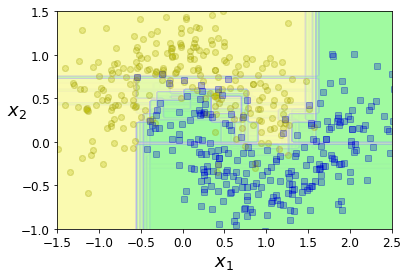

In [21]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state= 42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)
    
plt.show()

## Extra-Trees

When growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting. It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do).

A forest of such extremely random trees is simply called an ***Extremely Randomized Trees*** ensemble (or ***Extra-Trees*** for short). We can create an Extra-Trees classifier using Scikit-Learn’s `ExtraTreesClassifier class`. Its API isidentical to the `RandomForestClassifier` class. Similarly, the `ExtraTreesRegressor` class has the same API as the `RandomForestRegressor` class.

## Feature Importance

Yet another great quality of Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest).

Scikit-Learn computes this automatically for each feature after training, then it scales the results sothat the sum of all importances is equal to 1. You can access the result using the `feature_importances_variable`. For example, the following code trains a `RandomForestClassifier` on the iris dataset and outputs each feature’s importance. 

In [22]:
from sklearn.datasets import load_iris

iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [23]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

It seems that the most important featuresare the petal length ($44\%$) and width ($42\%$), while sepal length and width are rather unimportant in comparison ($11\%$ and $2\%$, respectively).

Similarly, if we train a Random Forest classifier on the MNIST dataset and plot each pixel’s importance, you get the image represented in figure below.

In [24]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [25]:
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [26]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


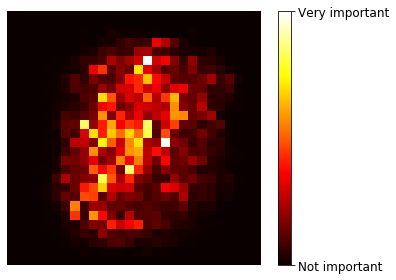

In [27]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig('mnist_feature_importance_plot')
plt.show()

## Boosting

***Boosting*** (originally called ***hypothesis boosting***) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are ***AdaBoost*** (short for ***Adaptive Boosting***) and ***Gradient Boosting**.

### AdaBoost

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. This is the technique used by ***AdaBoost***. 

For example, to build an AdaBoost classifier, a first base classifier (such as a Decision Tree) is trained and used to make predictions on the training set. The relative weight of misclassified training instances is then increased. A second classifier is trained using the updated weights and again it makes predictions on the training set, weights are updated, and so on.

Figure shows the decision boundaries of five consecutive predictors on the moons dataset (in this example, each predictor is a highly regularized `SVM` classifier with an `RBF` kernel). 

Saving figure boosting_plot


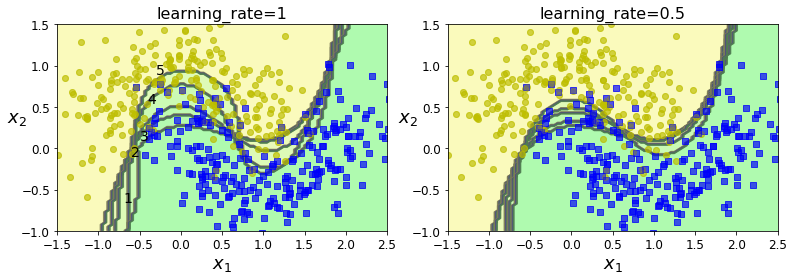

In [28]:
from sklearn.svm import SVC

m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    plt.subplot(subplot)
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.5, gamma="auto", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate={}".format(learning_rate), fontsize=16)
    if subplot == 121:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5, 0.10, "3", fontsize=14)
        plt.text(-0.4, 0.55, "4", fontsize=14)
        plt.text(-0.3, 0.90, "5", fontsize=14)

save_fig("boosting_plot")
plt.show()

The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and so on. 

The plot on the right represents the same sequence of predictors except that the learning rate is halved (i.e., the misclassified instance weights are boosted half as much at every iteration).

Let’s take a closer look at the ***AdaBoost*** algorithm. Each instance weight $w^{(i)}$ is initially set to $\frac{1}{m}$. A first predictor is trained and its weighted error rate $r_1$ is computed on the training set;

**Euqation 7-1. *Weighted error rate of the $j^{th}$ predictor***

$$ r_j = \frac{ \sum \limits _{i=1, \hat{y}^{(i)}_j \neq y^{(i)}} ^{m} w^{(i)}}{ \sum \limits _{i = 1} ^{m} w^{(i)} } $$, where $ \hat{y}^{(i)}_j $ is the $ j^{th} $ predictor's prediction for the $ i^{th} $ instance. 

The predictor’s weight $ \alpha_j $ is then computed using equation below, where $ \eta $ is the learning rate hyperparameter (defaults to 1). The more accurate the predictor is, the higher its weight will be. If it is just guessing randomly, then its weight will be close to zero. However, if it is most often wrong (i.e., less accurate than random guessing), then its weight will be negative.

**Equation 7-2. *Prediction weight***

$$ \alpha_j = \eta. log \frac{1 - r_j}{r_j} $$

Next the instance weights are updated using equation below: the misclassified instances are boosted.

**Equation 7-3. *Weight update rule***
for $ i = 1, 2, ..., m $

$$ w^{(i)} \leftarrow \begin{cases} w^{(i)} & if, \hat{y}^{(i)}_j = y^{(i)} \\ w^{(i)}\exp \left( \alpha_j \right) & if, \hat{y}^{(i)}_j \neq y^{(i)} \end{cases} $$

Then all the instance weights are normalized (i.e. divided by $ \sum \limits _{i=1} ^{m} w^{(i)} $).

Finally, a new predictor is trained using the updated weights, and the whole process is repeated (the new predictor’s weight is computed, the instance weights are updated, then another predictor is trained, and so on). The algorithm stops when the desired number of predictors is reached, or when a perfect predictor is found.

To make predictions, AdaBoost simply computes the predictions of all the predictors and weighs them using the predictor weights $ \alpha_j $. The predicted class is the one that receives the majority of weighted votes.

**Equation 7-4. *AdaBoost predictions***

$$ \hat{y} \left( \mathbf{x} \right) = \underbrace{argmax}_k \sum \limits _{j=1, \hat{y}_j \left( \mathbf{x} \right) = k } ^{N} \alpha_j $$

Scikit-Learn actually uses a multiclass version of AdaBoost called ***SAMME*** (which stands for ***Stagewise Additive Modeling using a Multiclass Exponential loss function***). When there are just two classes, ***SAMME*** is equivalent to ***AdaBoost***. Moreover, if the predictors can estimate class probabilities (i.e., if they have a `predict_proba()` method), Scikit-Learn can use a variant of ***SAMME*** called ***SAMME.R*** (the **R** stands for “Real”), which relies on class probabilities rather than predictions and generally performs better.

The following code trains an AdaBoost classifier based on 200 Decision Stumps using Scikit-Learn’s `AdaBoostClassifier` class (as you might expect, there is also an `AdaBoostRegressor` class). A Decision Stump is a Decision Tree with `max_depth=1` — in other words, a tree composed of a single decision node plus two leaf nodes. This is the default base estimator for the `AdaBoostClassifier` class:

In [29]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

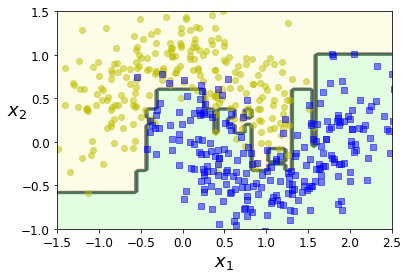

In [30]:
plot_decision_boundary(ada_clf, X, y)

If your AdaBoost ensemble is overfitting the training set, you can try reducing the number of estimators or more strongly regularizing the base estimator.

In [31]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

## Gradient Boosting

Another very popular Boosting algorithm is Gradient Boosting. Just like AdaBoost, Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

Let’s go through a simple regression example using Decision Trees as the base predictors. This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees (GBRT). First, let’s fit a `DecisionTreeRegressor` to the training set(for example, a noisy quadratic training set):

In [32]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [33]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [34]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

Then we train a third regressor on the residual errors made by the second predictor:

In [35]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the of all the trees:

In [36]:
X_new = np.array([[0.8]])

In [37]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [38]:
y_pred

array([0.75026781])

Figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. 

Saving figure gradient_boosting_plot


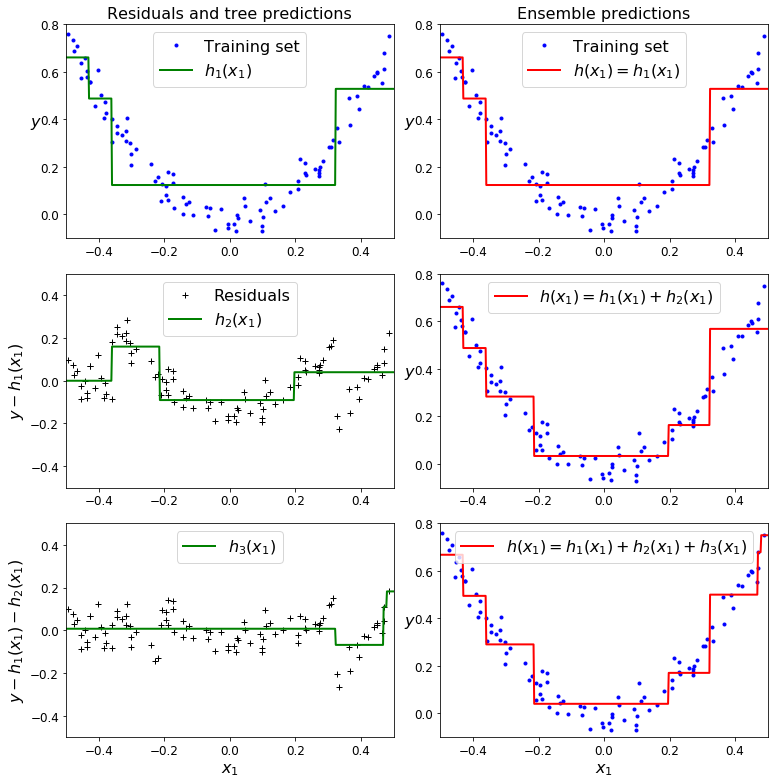

In [39]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right we can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

A simpler way to train GBRT ensembles is to use Scikit-Learn’s `GradientBoostingRegressor` class. Much like the `RandomForestRegressor` class, it has hyperparameters to control the growth of Decision Trees (e.g., `max_depth`, `min_samples_leaf`, and so on), as well as hyperparameters to control the ensemble training, such as the number of trees (`n_estimators`). The following code creates the same ensemble as the previous one:

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

The `learning_rate` hyperparameter scales the contribution of each tree. If we set it to a low value, such as 0.1, we will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called ***shrinkage***. 

Figure below shows two GBRT ensembles trained with a low learning rate: 

In [41]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Saving figure gbrt_learning_rate_plot


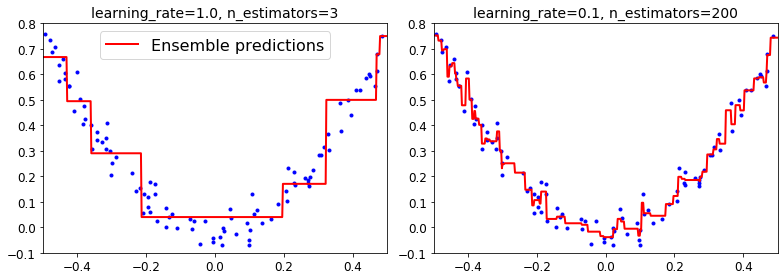

In [42]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

The one on the left does not have enough trees to fit the training set, while the one on the right has too many trees and overfits the training set.

## Gradient Boosting with Early stopping

In order to find the optimal number of trees, we can use early stopping. A simple way to implement this is to use the `staged_predict()` method: it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.). 

The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees:

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [44]:
min_error = np.min(errors)

The validation errors are represented on the left of the figure below, and the best model's predictions are represented on the right.

Saving figure early_stopping_gbrt_plot


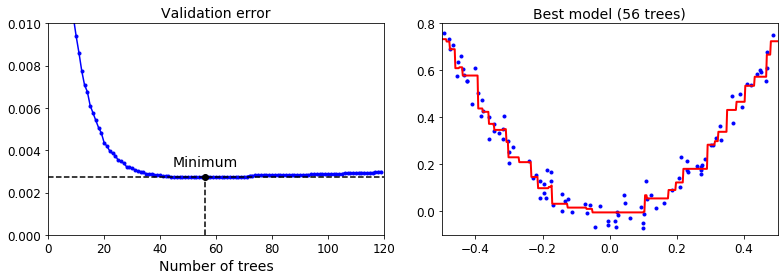

In [45]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

save_fig("early_stopping_gbrt_plot")
plt.show()

It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number). We can do so by setting `warm_start=True`, which makes Scikit-Learn keep existing trees when the `fit()` method is called, allowing incremental training. 

The following code stops training when the validation error does not improve for five iterations in a row:

In [46]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # early stopping

In [47]:
print(gbrt.n_estimators)

61


In [48]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


The `GradientBoostingRegressor` class also supports a `subsample` hyperparameter, which specifies the fraction of training instances to be used for training each tree. For example, if `subsample=0.25`, then each tree is trained on $25\%$ of the training instances, selected randomly. This trades a higher bias for a lower variance. It also speeds up training considerably. This technique is called ***Stochastic Gradient Boosting***.

It is possible to use Gradient Boosting with other cost functions. This is controlled by the `loss` hyperparameter. 

## Using XGBoost

In [49]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


ERROR: Exception:
Traceback (most recent call last):
  File "D:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 425, in _error_catcher
    yield
  File "D:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 507, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "D:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "D:\ProgramData\Anaconda3\lib\http\client.py", line 457, in read
    n = self.readinto(b)
  File "D:\ProgramData\Anaconda3\lib\http\client.py", line 501, in readinto
    n = self.fp.readinto(b)
  File "D:\ProgramData\Anaconda3\lib\socket.py", line 589, in readinto
    return self._sock.recv_into(b)
  File "D:\ProgramData\Anaconda3\lib\ssl.py", line 1071, in recv_into
    return self.read(nbytes, buffer)
  File "D:\ProgramData\Anaconda3\lib\ssl.py", line 929, in read
    return self._sslobj.read(len, buffer)
sock

In [50]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed")
    xgboost = None

Error: the xgboost library is not installed


In [51]:
if xgboost is not None: # not shown in this book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

In [52]:
if xgboost is not None: # not shown in this book
    xgb_reg.fit(X_train, y_train, 
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    print("Validation MSE:", val_error)

In [53]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

79.1 ns ± 3.61 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [54]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

50.1 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Exercise Solutions

### 8. Voting Classifier

Load the MNIST data, and split it into a training set, a validation set, and a test set (e.g., use 40,000 instances for training, 10,000 for validation, and 10,000 for testing). Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM. Next, try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier. Once you have found one, try it on the test set. How much better does it perform compared to the individual classifiers?

The data is already loaded.

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)

Let's train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM.

In [57]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

In [64]:
random_forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=10, random_state=42)
svm_clf = LinearSVC(random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [65]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the ", estimator)
    estimator.fit(X_train, y_train)

Training the  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Training the  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
    

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training the  MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


In [66]:
[estimator.score(X_val, y_val) for estimator in estimators]

[0.9469, 0.9492, 0.8626, 0.9635]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Next, lets try to combine them into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier.

In [67]:
from sklearn.ensemble import VotingClassifier

In [70]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [71]:
voting_clf = VotingClassifier(named_estimators)

In [72]:
voting_clf.fit(X_train, y_train)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_lea

In [73]:
voting_clf.score(X_val, y_val)

0.961

In [75]:
[estimator.score(X_val, y_val) for estimator in voting_clf.estimators_]

[0.9469, 0.9492, 0.8626, 0.9635]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `None` using `set_params()` like this:

In [76]:
voting_clf.set_params(svm_clf=None)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_lea

This is the updated the list of estimators:

In [77]:
voting_clf.estimators

[('random_forest_clf',
  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=None, max_features='auto',
                         max_leaf_nodes=None, max_samples=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, n_estimators=10,
                         n_jobs=None, oob_score=False, random_state=42, verbose=0,
                         warm_start=False)),
 ('extra_trees_clf',
  ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fractio

However, it did not update the list of trained estimators:

In [78]:
voting_clf.estimators_

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=10,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                 

So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators:

In [79]:
del voting_clf.estimators_[2]

Now, let's evaluate the `VotingClassifier` again:

In [80]:
voting_clf.score(X_val, y_val)

0.9632

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `"soft"`:

In [81]:
voting_clf.voting = "soft"

In [82]:
voting_clf.score(X_val, y_val)

0.9697

That's a significant improvement, and it's much better than each of the individual classifiers.

Let's try it on the test set.

In [84]:
voting_clf.score(X_test, y_test)

0.9656

In [85]:
[estimator.score(X_test, y_test) for estimator in voting_clf.estimators_]

[0.9437, 0.9474, 0.9599]

The voting classifier reduced the error rate from about $4.0\%$ for our best model (the `MLPClassifier`) to just $3.1\%$. That's about $22.5\%$ less errors, not bad!

### 9. Stacking Ensemble

Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image’s class. 

Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let’s evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble’s predictions. How does it compare to the voting classifier you trained earlier?

In [86]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [87]:
X_val_predictions

array([[5., 5., 5., 5.],
       [8., 8., 8., 8.],
       [2., 2., 2., 2.],
       ...,
       [7., 7., 7., 7.],
       [6., 6., 6., 6.],
       [7., 7., 7., 7.]], dtype=float32)

In [88]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [89]:
rnd_forest_blender.oob_score_

0.9613

We could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

Now let's evaluate the ensemble on the test set.

In [90]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [91]:
y_pred =  rnd_forest_blender.predict(X_test_predictions)

In [94]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9602

This stacking ensemble does not perform as well as the soft voting classifier we trained earlier. It's just as good as the best individual classfier.